In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from mnist_reader import load_mnist_df,show_mnist_image

seed = 128
rng = np.random.RandomState(seed)

### prepping the input data

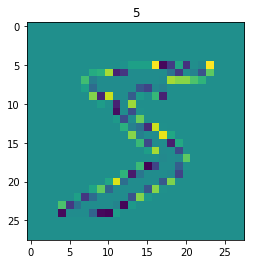

In [2]:
train_df = load_mnist_df('../data/')
test_df = load_mnist_df('../data/', test = True)
show_mnist_image(train_df,index=0)

In [3]:
X_train = np.array(train_df.drop('label', axis=1).astype('int8'))
X_train = X_train.astype('float32')/255
y_train = np.array(train_df.label)

X_test = np.array(test_df.drop('label', axis=1).astype('int8'))
X_test = X_test.astype('float32')/255
y_test = np.array(test_df.label)

In [4]:
split_size = int(X_train.shape[0]*0.7)

X_train, X_val = X_train[:split_size], X_train[split_size:]
y_train, y_val = y_train[:split_size], y_train[split_size:]

### setting up the model

In [20]:
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.num_features = 28*28
        self.output_num_units = 10 #number of classes

        self.hidden_layer0 = torch.nn.Sequential(torch.nn.Linear(self.num_features, 392),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(p=0.2))
        self.hidden_layer1 = torch.nn.Sequential(torch.nn.Linear(392, 392),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(p=0.2))
        self.out_layer = torch.nn.Linear(392, self.output_num_units)
        
    def forward(self, x):
        x = self.hidden_layer0(x)
        x = self.hidden_layer1(x)
        x = self.out_layer(x)
        return(x)

model = model()
        

In [21]:
# set remaining variables
epochs = 64
batch_size = 128
learning_rate = 0.0002 

loss_fn = torch.nn.CrossEntropyLoss()

# define optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
## helper functions
# preprocess a batch of dataset
def preproc(unclean_batch_x):
  """Convert values to range 0-1"""
  temp_batch = unclean_batch_x / unclean_batch_x.max()
 
  return temp_batch

# create a batch
def batch_creator(X_train, y_train, batch_size):
  dataset_length = X_train.shape[0]
  
  batch_mask = rng.choice(dataset_length, batch_size)
  
  batch_x = X_train[batch_mask]
  batch_x = preproc(batch_x)
  
  batch_y = y_train[batch_mask]
  
  return batch_x, batch_y

### Running the model

In [24]:
# train network
total_batch = int(X_train.shape[0]/batch_size)

epoch_list,epoch_train_accuracies,epoch_val_accuracies = [],[],[]
for epoch in range(epochs):
    avg_cost = 0
    for i in range(total_batch):
        # create batches
        batch_x, batch_y = batch_creator(X_train,y_train,batch_size)

        # pass that batch for training
        x, y = Variable(torch.from_numpy(batch_x)), Variable(torch.from_numpy(batch_y), requires_grad=False)
        pred = model(x)

        # get loss
        loss = loss_fn(pred, y)

        # perform backpropagation
        loss.backward()
        optimizer.step()

    x = Variable(torch.from_numpy(preproc(X_train)))
    pred_train = model(x)
    final_pred = np.argmax(pred_train.data.numpy(), axis=1)
    epoch_train_accuracy = accuracy_score(y_train, final_pred)
  
    x = Variable(torch.from_numpy(preproc(X_val)))
    pred_val = model(x)
    final_pred = np.argmax(pred_val.data.numpy(), axis=1)
    epoch_val_accuracy = accuracy_score(y_val, final_pred)
    
    epoch_list.append(epoch)
    epoch_train_accuracies.append(epoch_train_accuracy)
    epoch_val_accuracies.append(epoch_val_accuracy)
    
    print(epoch, epoch_train_accuracy, epoch_val_accuracy)
    
plt.plot(epoch_list,epoch_train_accuracies,epoch_val_accuracies) 
plt.show()

0 0.7660476190476191 0.5325
1 0.7490476190476191 0.5306666666666666
2 0.7468571428571429 0.5286111111111111
3 0.7630238095238095 0.5343888888888889
4 0.735904761904762 0.5151666666666667
5 0.7665952380952381 0.5351666666666667
6 0.78 0.5458888888888889
7 0.7579047619047619 0.5262777777777777
8 0.7816904761904762 0.5493333333333333
9 0.7783809523809524 0.5474444444444444
10 0.7745 0.537
11 0.7485 0.5271111111111111
12 0.7806666666666666 0.5357222222222222
13 0.7668809523809523 0.5412777777777777
14 0.7716666666666666 0.5399444444444444
15 0.763452380952381 0.5323888888888889
16 0.7588571428571429 0.5346666666666666
17 0.7653809523809524 0.5445555555555556
18 0.7689285714285714 0.5335
19 0.7968809523809524 0.5456111111111112
20 0.7688571428571429 0.5433333333333333
21 0.7816428571428572 0.5391111111111111
22 0.7743571428571429 0.5396111111111112


KeyboardInterrupt: 

In [28]:
model_save = model
torch.save(model_save ,"./model_20190718")

PicklingError: Can't pickle <class '__main__.model'>: it's not the same object as __main__.model

In [16]:
# testing set accuracy
x, y = Variable(torch.from_numpy(preproc(X_train))), Variable(torch.from_numpy(y_train), requires_grad=False)
pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(y_train, final_pred)

0.20607142857142857

In [17]:
# get validation accuracy
x, y = Variable(torch.from_numpy(preproc(X_val))), Variable(torch.from_numpy(y_val), requires_grad=False)
pred = model(x)
final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(y_val, final_pred)

0.1995

### viewing results

neural network predicts  3 this is  False


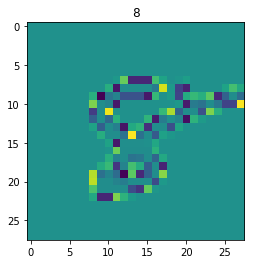

In [23]:
"""
viewing specific test cases
"""
test_index = np.random.randint(0,len(X_test))
x = Variable(torch.from_numpy(preproc(X_test[test_index])))
pred = model(x)
final_pred = np.argmax(pred.data.numpy())

print('neural network predicts ', final_pred,'this is ', final_pred == y_test[test_index])
show_mnist_image(test_df, index = test_index)